# Shapelet Discovery

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import stumpy

In [3]:
from datetime import datetime
import time

In [4]:
train = pd.read_csv("labelled_training_data.csv")

In [5]:
testing = pd.read_csv("labelled_testing_data.csv")
val = pd.read_csv("labelled_validation_data.csv")

In [6]:
data = pd.concat([train, testing, val])

In [7]:
data = data.sort_values(by=['timestamp'])

In [8]:
data = data.set_index("timestamp")

In [9]:
data.columns

Index(['processId', 'threadId', 'parentProcessId', 'userId', 'mountNamespace',
       'processName', 'hostName', 'eventId', 'eventName', 'stackAddresses',
       'argsNum', 'returnValue', 'args', 'sus', 'evil'],
      dtype='object')

In [10]:
data

,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
timestamp,,,,,,,,,,,,,,,
124.439221,381,381,1,101,4026532232,systemd-resolve,ip-10-100-1-129,41,socket,"[139913106282763, 139913103116537, 94901962555...",3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
124.439751,378,378,1,100,4026532231,systemd-network,ip-10-100-1-129,41,socket,"[140343254628619, 93967981149065, 93967990898192]",3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
124.439958,1,1,0,0,4026531840,systemd,ip-10-100-1-129,1005,security_file_open,"[140074839310116, 8103505641674583864]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",0,0
124.440007,1,1,0,0,4026531840,systemd,ip-10-100-1-129,257,openat,[],4,12,"[{'name': 'dirfd', 'type': 'int', 'value': -10...",0,0
124.440037,1,1,0,0,4026531840,systemd,ip-10-100-1-129,5,fstat,[140074839307913],2,0,"[{'name': 'fd', 'type': 'int', 'value': 12}, {...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954.587254,1,1,0,0,4026531840,systemd,ip-10-100-1-120,257,openat,[],4,39,"[{'name': 'dirfd', 'type': 'int', 'value': -10...",0,0
3954.587429,1,1,0,0,4026531840,systemd,ip-10-100-1-120,5,fstat,[],2,0,"[{'name': 'fd', 'type': 'int', 'value': 39}, {...",0,0
3954.587480,1,1,0,0,4026531840,systemd,ip-10-100-1-120,217,getdents64,[],3,576,"[{'name': 'fd', 'type': 'int', 'value': 39}, {...",0,0


In [11]:
data["processId"] = data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
data["parentProcessId"] = data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
data["userId"] = data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
data["mountNamespace"] = data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
data["eventId"] = data["eventId"]  # Keep eventId values (requires knowing max value)
data["returnValue"] = data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))

In [12]:
data["eventId"].unique()

array([  41, 1005,  257,    5,    3, 1006,   87, 1003,  114,  113,   42,
         51,  288,   21, 1010,   49,    6,  217,    4,   56,   91,  157,
         62,  292,   33,   59, 1004,  263,  166,   43,   32,  106,  105,
         88,  165,   94,  133,  260,   90,  321,  319,   50,  269,  123,
        122,    2], dtype=int64)

In [13]:
 #from sklearn.preprocessing import MinMaxScaler

In [14]:
#scaler = MinMaxScaler(feature_range=(0,1))

In [15]:
#old_shape = data['eventId'].shape

In [16]:
#data['eventId'] = scaler.fit_transform(data['eventId'].to_numpy().reshape(-1,1)).reshape(old_shape)

In [17]:
#data['eventId'].unique()

In [18]:
dataset = data[['processId', 'parentProcessId','userId','mountNamespace','eventId','argsNum','returnValue', 'sus']]

In [19]:
dataset

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,sus
timestamp,,,,,,,,
124.439221,1,0,0,1,41,3,1,0
124.439751,1,0,0,1,41,3,1,0
124.439958,0,0,0,0,1005,4,0,0
124.440007,0,0,0,0,257,4,1,0
124.440037,0,0,0,0,5,2,0,0
...,...,...,...,...,...,...,...,...
3954.587254,0,0,0,0,257,4,1,0
3954.587429,0,0,0,0,5,2,0,0
3954.587480,0,0,0,0,217,3,1,0


In [20]:
dataset.isna().sum()

processId          0
parentProcessId    0
userId             0
mountNamespace     0
eventId            0
argsNum            0
returnValue        0
sus                0
dtype: int64

In [21]:
dataset['sus'].value_counts()

sus
0    967564
1    173514
Name: count, dtype: int64

In [22]:
dataset = dataset.reset_index()

C:\Users\MORYBA.KOUATE\AppData\Local\Temp\ipykernel_7524\434335537.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  event_counts_notsus = dataset[dataset['sus']==0].groupby(bins).size()
C:\Users\MORYBA.KOUATE\AppData\Local\Temp\ipykernel_7524\434335537.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  event_counts_sus = dataset[dataset['sus']==1].groupby(bins).size()


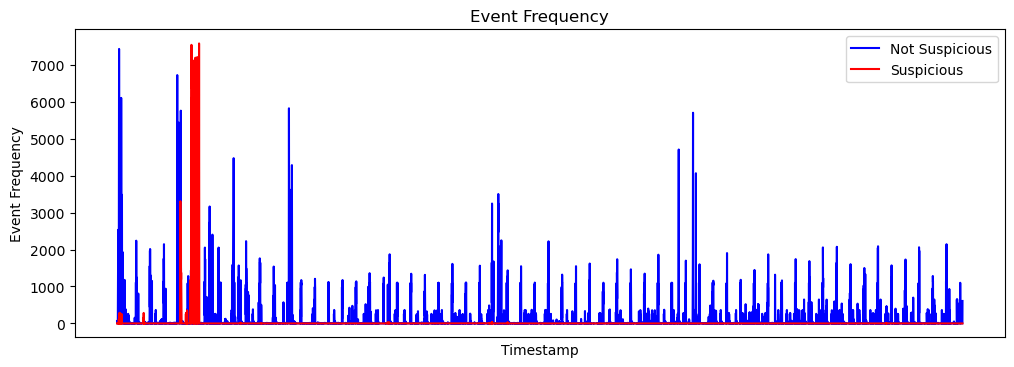

In [23]:
bins = pd.cut(dataset['timestamp'], bins=10000)
event_counts_notsus = dataset[dataset['sus']==0].groupby(bins).size()
event_counts_sus = dataset[dataset['sus']==1].groupby(bins).size()
event_counts_notsus.plot(kind='line', color='blue', label='Not Suspicious', figsize=(12, 4))
event_counts_sus.plot(kind='line', color='red', label='Suspicious')
plt.xlabel('Timestamp')
plt.ylabel('Event Frequency')
plt.title('Event Frequency')
plt.xticks([])
plt.legend()
plt.show()

In [24]:
def merge_sequences(df):
    return df.assign(
        # create a new col called separator with only NaNs
        separator=np.nan
        # create a stack series and convert it back into a dataframe with the cxorrect formatting
        ).stack(dropna=False).to_frame().reset_index(drop=True).rename({0: "centroid"}, axis=1)

In [25]:
sus = merge_sequences(dataset[dataset['sus']==1])

C:\Users\MORYBA.KOUATE\AppData\Local\Temp\ipykernel_7524\1375280662.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return df.assign(


In [26]:
notsus = merge_sequences(dataset[dataset['sus']==0])

C:\Users\MORYBA.KOUATE\AppData\Local\Temp\ipykernel_7524\1375280662.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return df.assign(


In [27]:
#fig, ax = plt.subplots(2,figsize=(24,8),sharex=True)
#ax[0].set_title('OS')
#ax[0].plot(OS)
#ax[1].set_title('Not_OS')
#ax[1].plot(Not_OS)

In [28]:
sus

,centroid
0,128.548679
1,1.000000
2,1.000000
3,1.000000
4,0.000000
...,...
1735135,4.000000
1735136,2.000000
1735137,0.000000
1735138,1.000000


In [29]:
sus.isna().sum()

centroid    173514
dtype: int64

In [30]:
sus['centroid'] = sus['centroid'].fillna(sus['centroid'].mean())

In [31]:
sus.isna().sum()

centroid    0
dtype: int64

In [32]:
notsus.isna().sum()

centroid    967564
dtype: int64

In [33]:
notsus['centroid'] = notsus['centroid'].fillna(notsus['centroid'].mean())

In [34]:
notsus.isna().sum()

centroid    0
dtype: int64

In [35]:
sus_part = sus.head(200000)

In [36]:
notsus_part = notsus.head(200000)

In [37]:
m = 2000
profile_sus_sus = stumpy.stump(sus_part['centroid'], m)[:, 0].astype(float)

In [38]:
profile_sus_notsus = stumpy.stump(sus_part['centroid'].astype(float), m, notsus_part['centroid'].astype(float), ignore_trivial=False)[:, 0].astype(float)

In [39]:
import seaborn as sns

C:\Users\MORYBA.KOUATE\.conda\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\MORYBA.KOUATE\.conda\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

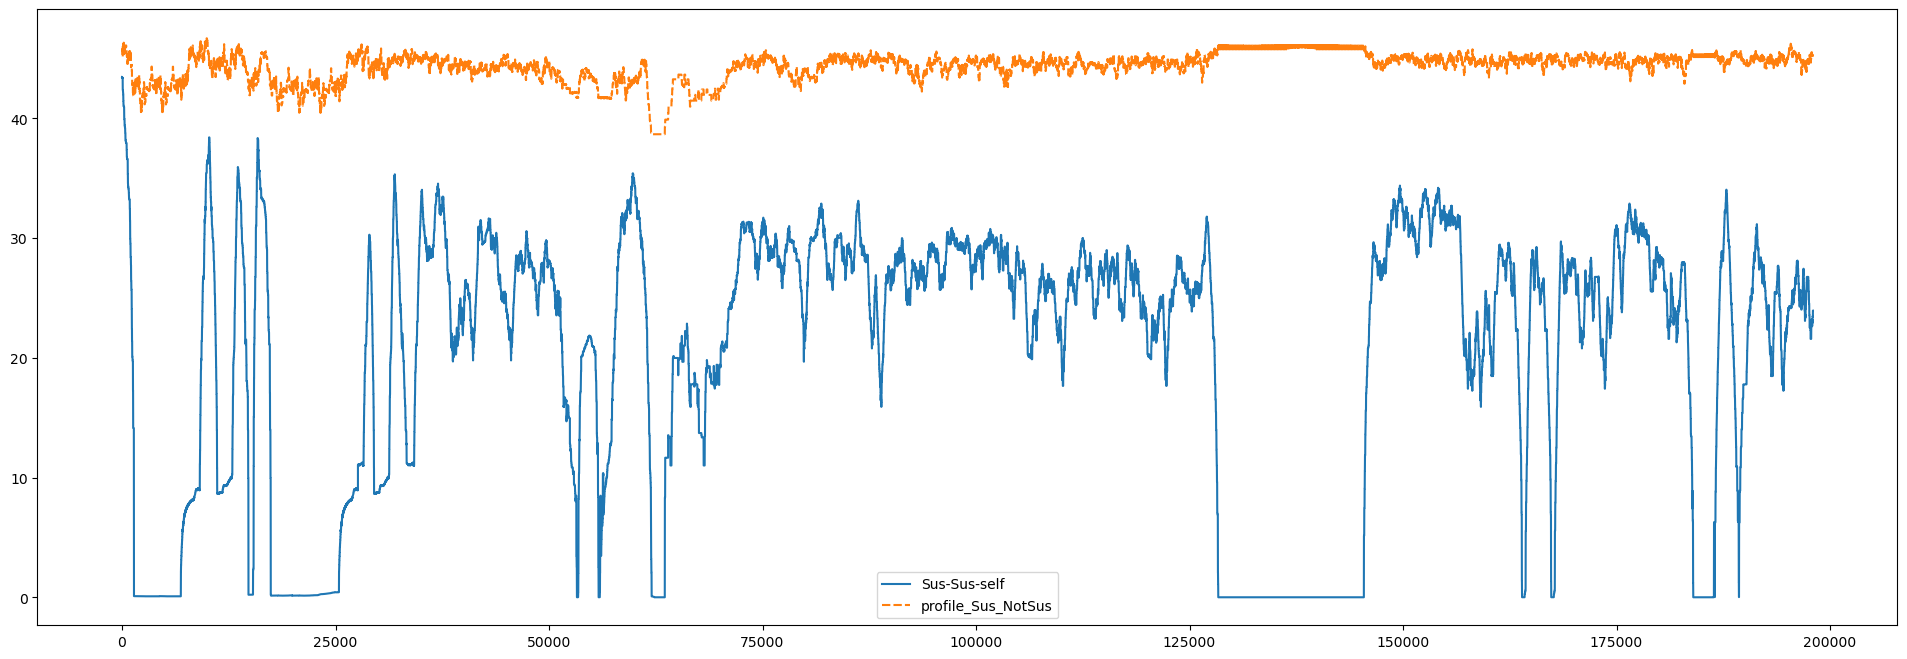

In [40]:
fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(data={'Sus-Sus-self':profile_sus_sus,'profile_Sus_NotSus':profile_sus_notsus}, ax=ax)

In [41]:
profile_diff = profile_sus_notsus - profile_sus_sus

In [42]:
profile_diff

array([ 2.47923829,  2.47936945,  2.47936945, ..., 21.21512512,
       21.21512512, 21.21512512])

In [43]:
worst_matches = np.argpartition(profile_diff,-10)[-10:]

In [44]:
worst_matches

array([142658, 143168, 142149, 142148, 141638, 141639, 143170, 141640,
       143169, 142150], dtype=int64)

In [45]:
sus_shapelets = []
notsus_shapelets = []

for idx in worst_matches:
    sus_shapelet = sus_part['centroid'][idx:idx+m]    
    sus_shapelets.append(sus_shapelet)

# Building a Shapelet Based Model

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
dataset.shape

(1141078, 9)

In [48]:
dataset = dataset.head(200000)

In [49]:
X = dataset[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]]

In [50]:
y = dataset['sus']

In [60]:
reference_shapelet.head

array([  1.       ,  60.3130387, 412.818285 , ..., 257.       ,
         4.       ,   1.       ])

In [62]:
X_train.shape

(134000, 7)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [53]:
def get_shapelet_distance(shapelet, train):
    X = []
    for s, sample in enumerate(train):
        D = stumpy.mass(shapelet, sample)
        X.append(D.min())
    
    return np.array(X).reshape(-1,1)

In [57]:
X_train.values.astype('float64').shape

(134000, 7)

In [66]:
sus_shapelet_part = sus_shapelet.head(7)

In [70]:
sus_shapelet_part.values

array([412.816191,   1.      ,   1.      ,   0.      ,   0.      ,
       257.      ,   4.      ])

In [71]:
reference_shapelet = sus_shapelet_part.values

In [72]:
X_train_dist = get_shapelet_distance(reference_shapelet, X_train.values.astype('float64'))

In [73]:
X_test_dist = get_shapelet_distance(reference_shapelet, X_test.values.astype('float64'))

In [74]:
from sklearn.tree import DecisionTreeClassifier

In [75]:
model = DecisionTreeClassifier()

model.fit(X_train_dist, y_train)

DecisionTreeClassifier()

In [76]:
from sklearn.metrics import accuracy_score

In [78]:
y_pred = model.predict(X_test_dist)
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.9873181818181819

# Model Convolutional Neural Network

In [79]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import tensorflow as tf
from keras.layers import Flatten, Dense, Input, Dropout, Conv1D, BatchNormalization, MaxPooling1D, Flatten, LSTM, Bidirectional, Embedding, Concatenate, Reshape
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop, Adamax

In [83]:
random_normal_initializer = tf.keras.initializers.RandomNormal(mean=0.1, stddev=0.1, seed=51)
model1 = Sequential([Conv1D(256, 3, input_shape=(7, 1), activation='relu', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer),
  Dropout(0.2), Flatten(), Dense(units=128, activation='relu', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer),
  Dense(units=1, activation='sigmoid', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer)])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 5, 256)            1024      
                                                                 
 dropout_1 (Dropout)         (None, 5, 256)            0         
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 165,121
Trainable params: 165,121
Non-trainable params: 0
_________________________________________________________________


In [85]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

In [88]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [90]:
model1.compile(optimizer=Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=False)
history1 = model1.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=100, verbose=1, batch_size=10000,callbacks=[callback])

Epoch 1/100
15/15 [==============================] - 1s 65ms/step - loss: 1.8535 - accuracy: 0.9629 - val_loss: 2.7742 - val_accuracy: 0.9886
Epoch 2/100
15/15 [==============================] - 1s 69ms/step - loss: 2.2687 - accuracy: 0.9895 - val_loss: 1.2312 - val_accuracy: 0.9886
Epoch 3/100
15/15 [==============================] - 1s 61ms/step - loss: 1.1921 - accuracy: 0.9735 - val_loss: 1.9255 - val_accuracy: 0.9886
Epoch 4/100
15/15 [==============================] - 1s 63ms/step - loss: 1.5538 - accuracy: 0.9895 - val_loss: 1.1653 - val_accuracy: 0.9886
Epoch 5/100
15/15 [==============================] - 1s 63ms/step - loss: 0.5379 - accuracy: 0.9839 - val_loss: 0.3817 - val_accuracy: 0.9886
Epoch 6/100
15/15 [==============================] - 1s 65ms/step - loss: 0.2941 - accuracy: 0.9865 - val_loss: 0.1898 - val_accuracy: 0.9891
Epoch 7/100
15/15 [==============================] - 1s 63ms/step - loss: 0.2067 - accuracy: 0.9878 - val_loss: 0.1877 - val_accuracy: 0.9891
Epoch 

In [91]:
# Model evaluation
accuracy1 = model1.evaluate(X_test,y_test)
print(f"Accuracy of the second model: {(100*accuracy1[1]):.1f}%")

625/625 [==============================] - 1s 1ms/step - loss: 0.1222 - accuracy: 0.9926
Accuracy of the second model: 99.3%


In [93]:
def plot_training(history):
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Get the training and validation loss
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Plot the accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot the loss
    plt.figure(figsize=(8, 4))
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    return(plt)

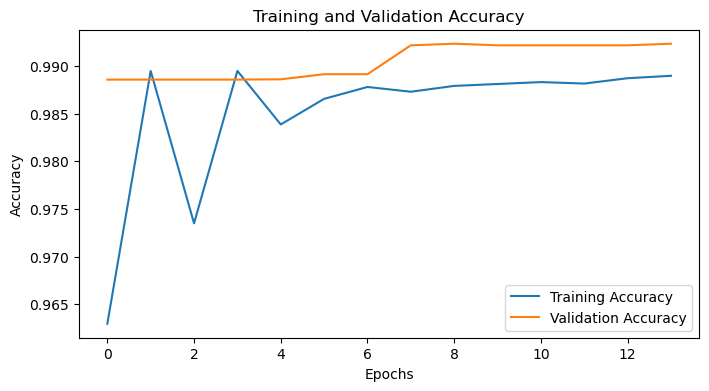

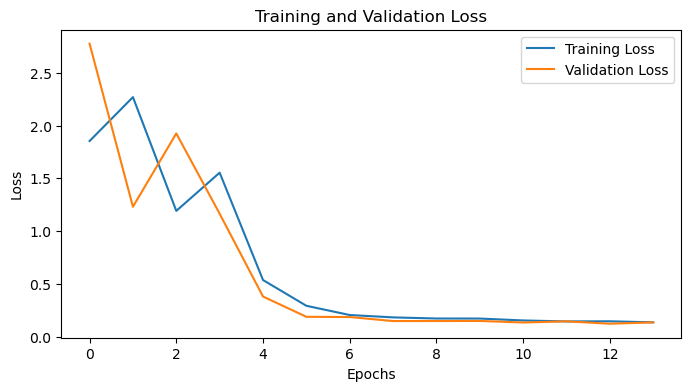

In [94]:
plot_training(history1);

# Long Short Term Memory Network

In [95]:
random_normal_initializer = tf.keras.initializers.RandomNormal(mean=0.1, stddev=0.1, seed=51)
model1 = Sequential([
  LSTM(32, input_shape=(7, 1), activation='relu', kernel_initializer='lecun_normal',
       bias_initializer=random_normal_initializer, return_sequences=True),
  Dropout(0.2),
  LSTM(32, activation='relu', kernel_initializer='lecun_normal',
       bias_initializer=random_normal_initializer, return_sequences=True),
  Dropout(0.2),
  LSTM(32, activation='relu', kernel_initializer='lecun_normal',
       bias_initializer=random_normal_initializer, return_sequences=True),
  Dropout(0.2),
  LSTM(32, activation='relu', kernel_initializer='lecun_normal',
       bias_initializer=random_normal_initializer, return_sequences=True),
  Dropout(0.2),
  Flatten(),
  Dense(units=128, activation='relu', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer),
  Dense(units=1, activation='sigmoid', kernel_initializer='lecun_normal', bias_initializer=random_normal_initializer)
])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 32)             4352      
                                                                 
 dropout_2 (Dropout)         (None, 7, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 32)             8320      
                                                                 
 dropout_3 (Dropout)         (None, 7, 32)             0         
                                                                 
 lstm_2 (LSTM)               (None, 7, 32)             8320      
                                                                 
 dropout_4 (Dropout)         (None, 7, 32)             0         
                                                                 
 lstm_3 (LSTM)               (None, 7, 32)            

In [96]:
model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=False)
history1 = model1.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=100, verbose=1, batch_size=10000,callbacks=[callback])



Epoch 1/100
15/15 [==============================] - 5s 202ms/step - loss: 1.6277 - accuracy: 0.7103 - val_loss: 0.1726 - val_accuracy: 0.9829
Epoch 2/100
15/15 [==============================] - 3s 177ms/step - loss: 0.1613 - accuracy: 0.9834 - val_loss: 0.1589 - val_accuracy: 0.9829
Epoch 3/100
15/15 [==============================] - 2s 153ms/step - loss: 0.1142 - accuracy: 0.9834 - val_loss: 0.0898 - val_accuracy: 0.9829
Epoch 4/100
15/15 [==============================] - 2s 131ms/step - loss: 0.0896 - accuracy: 0.9834 - val_loss: 0.0905 - val_accuracy: 0.9829
Epoch 5/100
15/15 [==============================] - 3s 221ms/step - loss: 0.0888 - accuracy: 0.9834 - val_loss: 0.0892 - val_accuracy: 0.9829
Epoch 6/100
15/15 [==============================] - 3s 163ms/step - loss: 0.0881 - accuracy: 0.9834 - val_loss: 0.0885 - val_accuracy: 0.9829


In [97]:
# Model evaluation
accuracy1 = model1.evaluate(X_test,y_test)
print(f"Accuracy of model1: {(100*accuracy1[1]):.1f}%")

625/625 [==============================] - 3s 4ms/step - loss: 0.0841 - accuracy: 0.9836
Accuracy of model1: 98.4%


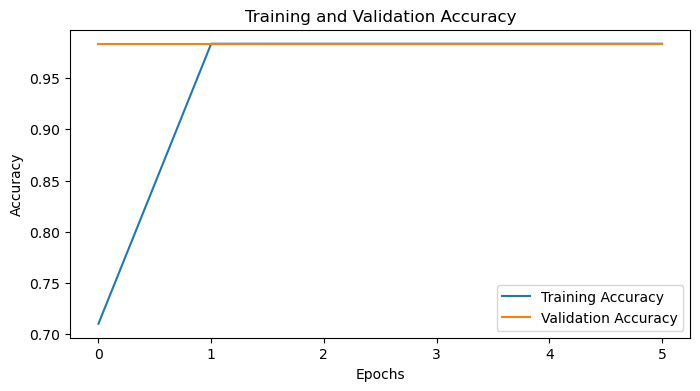

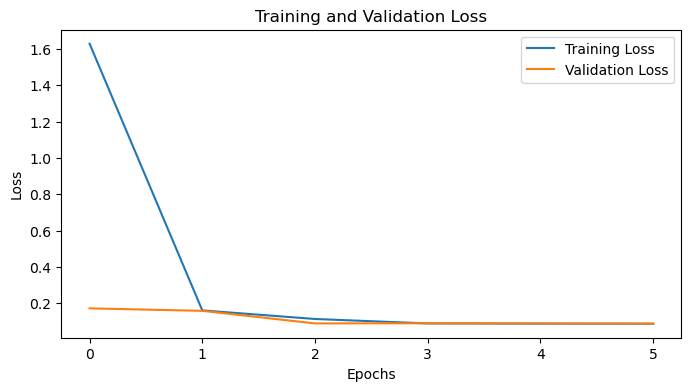

In [98]:
plot_training(history1);